导入必要的Python库：

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import pickle
import time
from Data import Data

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

设置__可视化参数__：

In [2]:
mpl.rcParams['figure.figsize'] = (20, 6)
mpl.rcParams['axes.grid'] = False

初始化__随机种子__：

In [3]:
tf.random.set_seed(2020)

设置默认__浮点数类型__：

In [4]:
tf.keras.backend.set_floatx('float64')

载入数据：

In [5]:
# Alibaba dataset
# data = dict()
# for filename in os.listdir('.'):
#     if filename.endswith('.pickle'):
#         with open(filename, 'rb') as f:
#             data[filename[filename.rindex('_') + 1:filename.index('.')]] = pickle.load(f)[3000:]
# data = pd.DataFrame(data)
# data.head(5)

# Bustracker Dataset
data = pd.read_csv('BusTrackerData/1.csv',names=['date', 'freq'])
# data = pd.read_csv('SDSS/DTW/149.csv',names=['date', 'freq'])
data = data.dropna(axis=0,how='any')
data['date'] = pd.to_datetime(data['date'])
# df.reset_index(drop=True,inplace=True)
data = data.set_index('date')

# SDSS Dataset
# data = pd.read_csv('SDSS/DTW149.csv',names=['date', 'freq'])
# data = data.dropna(axis=0,how='any')
# data['date'] = pd.to_datetime(data['date'])
# # df.reset_index(drop=True,inplace=True)
# data = data.set_index('date')

    
data.head(5)

,freq
date,
2016-11-29 21:20:00,288.0
2016-11-29 21:30:00,292.0
2016-11-29 21:40:00,368.0
2016-11-29 21:50:00,335.0
2016-11-29 22:00:00,242.0


In [6]:
print(len(data['freq']))

8224


数据可视化：

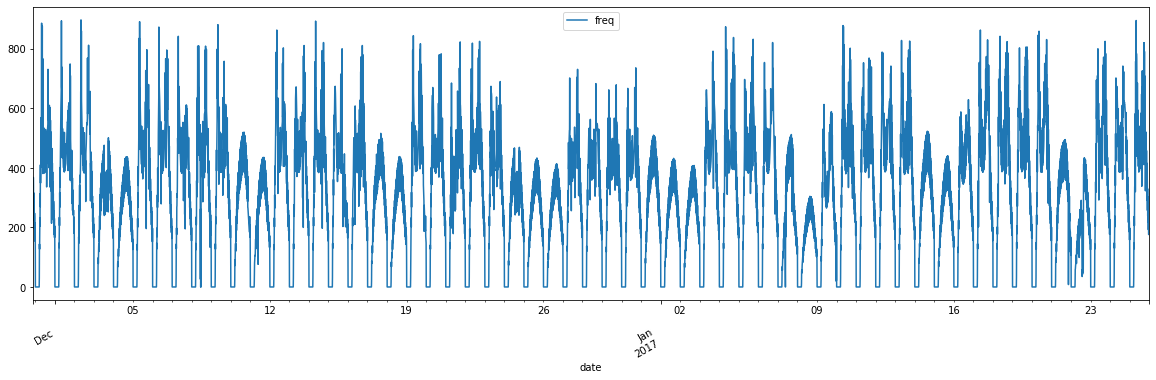

In [7]:
data.plot(subplots=True)
plt.show()

选择__预测目标__：

In [8]:
for i, column in enumerate(data.columns):
    print('{}: {}'.format(i, column))
# target = int(input('target (0~{}):'.format(len(data.columns) - 1)))
target = 0
assert 0 <= target < len(data.columns)
print('Your choice:', data.columns[target])

0: freq
Your choice: freq


拆分__训练数据__和__验证数据__：

In [9]:
# TRAIN_SPLIT = 800
TRAIN_SPLIT = 7000  # Bustracker
# TRAIN_SPLIT = 4000  # SDSS

UNI_DATA = True
HISTORY_SIZE, TARGET_SIZE, STEP, SINGLE_STEP = 30, 5, 1, True
data = Data(data.values, target, TRAIN_SPLIT, HISTORY_SIZE, TARGET_SIZE, UNI_DATA, STEP, SINGLE_STEP)
print(data.x_train.shape, data.x_train_target.shape, data.y_train.shape)
# print(data.x_train[0])
# print(data.y_train[0])

Data Std [205.60279312]
Data Mean [304.03428571]
(6970, 30, 1) (6970, 30, 1) (6970, 1)


In [10]:
print(data.x_val.shape, data.x_val_target.shape, data.y_val.shape)

(1189, 30, 1) (1189, 30, 1) (1189, 1)


定义__模型__：

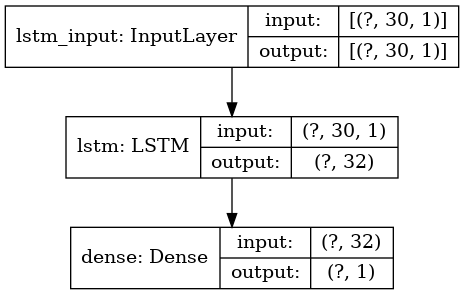

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=32, return_sequences=False, input_shape=data.x_train.shape[-2:]),
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1 if SINGLE_STEP else TARGET_SIZE)
])

tf.keras.utils.plot_model(model, show_shapes=True)

定义损失函数：

In [12]:
mse = tf.keras.losses.MeanSquaredError()

def model_loss(y_pred, y):
    return mse(y_pred, y)

设置__优化器__：

In [13]:
model_optimizer = tf.keras.optimizers.Adam()

定义__训练步__：

In [14]:
@tf.function
def train_step(x, x_target, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)

        loss = model_loss(y_pred, y)

        gradients = tape.gradient(loss, model.trainable_variables)
        model_optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

定义__评估函数__：

In [15]:
def evaluate(model, data):
    y_true, y_pred = [], []
    for (x, x_target, y) in data:
        y_true.extend(y)
        y_pred.extend(model(x))
    return mse(y_true, y_pred)

定义__训练循环__：

In [16]:
def train(data_train, data_val, epochs, steps_per_epoch):
    loss_history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        start = time.time()

        gen_loss, disc_loss, train_loss, val_loss = None, None, None, None
        for step, (x, x_target, y) in enumerate(data_train.repeat()):
            if step >= steps_per_epoch:
                break
            gen_loss = train_step(x, x_target, y)
        train_loss = evaluate(model, data_train)
        val_loss = evaluate(model, data_val)

        loss_history['train_loss'].append(train_loss)
        loss_history['val_loss'].append(val_loss)

        print('Time for epoch {} is {:.3f} sec. gen_loss: {:.6f}, train_loss: {:.6f}, val_loss: {:.6f}'.format(
            epoch + 1, time.time() - start, gen_loss, train_loss, val_loss
        ))

    return loss_history

封装__训练数据集__和__验证数据集__：

In [17]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
data_train, data_val = data.dataset(BUFFER_SIZE, BATCH_SIZE)

模型__训练__：

In [ ]:
EPOCHS = 50
STEPS_PER_EPOCH = 50
train_history = train(data_train, data_val, EPOCHS, STEPS_PER_EPOCH)

模型__评估__：

In [ ]:
final_loss = evaluate(model, data_val)
print('Evaluation MSE LOSS:', final_loss.numpy())
generator.save('Model/BusTracker/'+ 'LSTM-'+str(TARGET_SIZE)+'.h5')

__损失函数__变化趋势：

In [ ]:
def plot_train_history(history, title):
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = range(len(train_loss))
    plt.figure()
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(train_history, 'Training and validation loss')

结果展示：

In [ ]:
y_predict = model(data.x_val)
plt.plot(data.y_val, 'b-', label='actual')
plt.plot(y_predict, 'r--', label='predict')
plt.legend()
plt.show()